# Data Pre-Processing

In [24]:
#First dataset

#Aptos-2019 
#https://www.kaggle.com/datasets/mariaherrerot/aptos2019?resource=download

#The APTOS 2019 Blindness Detection dataset is a publicly available collection of retinal fundus images designed to support the development of machine learning models for detecting diabetic retinopathy (DR)

#Dataset Overview
#Total Images: 3,662 retinal fundus images
#Image Format: RGB images captured using fundus photography under various imaging conditions
#Image Resolutions: Varied, including dimensions such as 2416×1736, 1050×1050, and 819×614 pixels


#Labeling: Each image is labeled by clinicians based on the International Clinical Diabetic Retinopathy (ICDR) severity scale, ranging from 0 to 4:

# 0: No DR

# 1: Mild DR

# 2: Moderate DR

# 3: Severe DR

# 4: Proliferative DR


# The dataset exhibits class imbalance, with the following distribution: ​
# PMC

# Class 0 (No DR): 1,805 images (49.3%)

# Class 1 (Mild DR): 370 images (10.1%)

# Class 2 (Moderate DR): 999 images (27.3%)

# Class 3 (Severe DR): 193 images (5.3%)

# Class 4 (Proliferative DR): 295 images (8.1%)​

In [44]:
#Loading the CSV files

import pandas as pd

# Paths
train_csv_path = 'data/train.csv'
val_csv_path = 'data/valid.csv'
test_csv_path = 'data/test.csv'

# Load
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Show
print("Train CSV:")
print(train_df.head())
print("\nValidation CSV:")
print(val_df.head())
print("\nTest CSV:")
print(test_df.head())

Train CSV:
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

Validation CSV:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Test CSV:
        id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


In [45]:
# Each CSV (train_1.csv, valid.csv, test.csv) has id_code: image filename and diagnosis: label (integers like 0, 1, 2, 4)
# Diagnosis is a multiclass classification target (e.g., Diabetic Retinopathy stages)

In [46]:
import os

#Image paths based on id_code
train_df['image_path'] = train_df['id_code'].apply(lambda x: os.path.join('data', 'train_images', f'{x}.png'))
val_df['image_path'] = val_df['id_code'].apply(lambda x: os.path.join('data', 'val_images', f'{x}.png'))
test_df['image_path'] = test_df['id_code'].apply(lambda x: os.path.join('data', 'test_images', f'{x}.png'))

#Quick check
print(train_df[['image_path', 'diagnosis']].head())
print(val_df[['image_path', 'diagnosis']].head())
print(test_df[['image_path', 'diagnosis']].head())

                           image_path  diagnosis
0  data/train_images/1ae8c165fd53.png          2
1  data/train_images/1b329a127307.png          1
2  data/train_images/1b32e1d775ea.png          4
3  data/train_images/1b3647865779.png          0
4  data/train_images/1b398c0494d1.png          0
                         image_path  diagnosis
0  data/val_images/000c1434d8d7.png          2
1  data/val_images/001639a390f0.png          4
2  data/val_images/0024cdab0c1e.png          1
3  data/val_images/002c21358ce6.png          0
4  data/val_images/005b95c28852.png          0
                          image_path  diagnosis
0  data/test_images/e4dcca36ceb4.png          0
1  data/test_images/e4e343eaae2a.png          2
2  data/test_images/e4f12411fd85.png          4
3  data/test_images/e50b0174690d.png          0
4  data/test_images/e5197d77ec68.png          0


Trying to load: data/train_images/1ae8c165fd53.png
Image size: (3216, 2136)


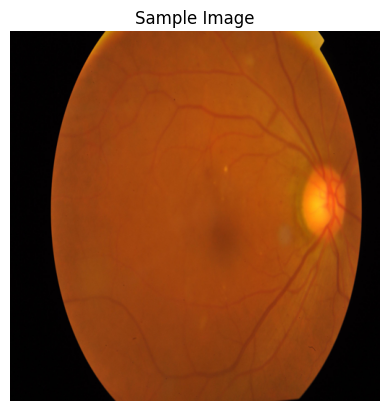

In [47]:
from PIL import Image
import matplotlib.pyplot as plt

# Pick one single image
one_img_path = train_df.iloc[0]['image_path']
print(f"Trying to load: {one_img_path}")

# SAFELY load the image
try:
    img = Image.open(one_img_path).convert('RGB')  # RGB directly
    print(f"Image size: {img.size}")  # (width, height)

    # Resize (downscale to 512x512 to be safe)
    img = img.resize((512, 512))

    # Show
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Image')
    plt.show()

except Exception as e:
    print(f"Error loading image: {e}")

In [48]:
import pandas as pd
import os

#Loading the training set
train_df = pd.read_csv('data/train.csv')

#List all actual filenames in the folder (without extension)
actual_images = set([filename.split('.')[0] for filename in os.listdir('data/train_images')])

#Get the set of ids from the CSV
#Making sure all are strings
csv_images = set(train_df['id_code'].astype(str))  

#Find which IDs are missing
missing_images = csv_images - actual_images
extra_images = actual_images - csv_images

print(f"Missing images: {len(missing_images)}")
if missing_images:
    print(missing_images)

print(f"\nExtra images (present but not in CSV): {len(extra_images)}")
if extra_images:
    print(extra_images)


Missing images: 0

Extra images (present but not in CSV): 1
{''}


In [51]:
#Creating a dataloader

from torch.utils.data import Dataset
from PIL import Image
import os

class EyeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.data.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert('RGB')
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [52]:
#Initialize your dataset
train_dataset = EyeDataset(csv_file='data/train.csv', root_dir='data/train_images')

In [55]:
#Apply transformations
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = EyeDataset(csv_file='data/train.csv', root_dir='data/train_images', transform=transform)

In [56]:
#Creating the dataloader 
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [57]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


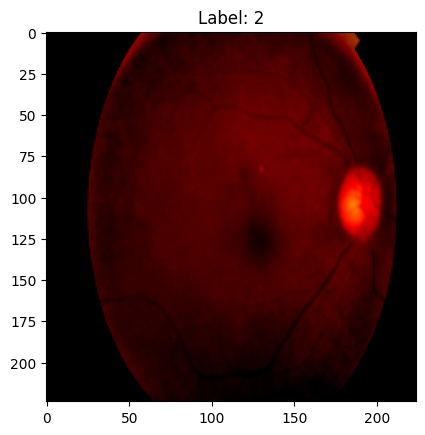

In [65]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]
# because torch uses [C, H, W]
plt.imshow(img.permute(1, 2, 0)) 
plt.title(f"Label: {label}")
plt.show()

In [85]:
class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.data.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [67]:
#make a DataLoader for test set
test_dataset = TestDataset(csv_file='data/test.csv', root_dir='data/test_images', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Teacher & Student Model

In [69]:
 # ViT Small (vit_s_16) pretrained on ImageNet

In [71]:
# Role	     Model	                Notes
# Teacher	ViT Small (vit_s_16)	Rich knowledge
# Student	MobileNetV2	            Light and fast for Jetson Nano

In [72]:
# Loss	Purpose
# 1. CrossEntropyLoss	Makes the student match the true labels (normal classification)
# 2. KLDivLoss (soft labels)	Makes the student match the teacher's "soft" predictions (distillation)

In [78]:
import timm
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ViT Small from timm (pretrained)
teacher = timm.create_model('vit_small_patch16_224', pretrained=True)

teacher.eval()
teacher.to(device)


/opt/anaconda3/envs/by2385/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [84]:
import torch.nn as nn

# After loading the teacher model
teacher_projector = nn.Linear(1000, num_classes)  # 1000 to 5 class projection
teacher_projector = teacher_projector.to(device)
teacher_projector.eval()


Linear(in_features=1000, out_features=5, bias=True)

# Set Up Optimizer and Loss Functions

In [80]:
# Setting up Optimizer
import torch.optim as optim

# start with lr=0.001
optimizer = optim.Adam(student.parameters(), lr=1e-3)  

#student.parameters() We only optimize student weights



In [81]:
#Setting up Loss Functions

import torch.nn as nn

# Loss functions
ce_loss_fn = nn.CrossEntropyLoss()
kd_loss_fn = nn.KLDivLoss(reduction='batchmean')  # batchmean is better for distillation

# ce_loss_fn is classic classification loss
# kd_loss_fn is for distillation (comparing soft predictions)

In [82]:
# blending controls" between hard and soft labels
temperature = 4.0
alpha = 0.5

# Training Loop

In [94]:
teacher = teacher.to(device)
teacher_projector = teacher_projector.to(device)
student = student.to(device)

In [95]:
images = images.to(device)
labels = labels.to(device)

In [98]:
import torch
import torch.nn.functional as F

if torch.backends.mps.is_available():
    device = torch.device("mps")  
else:
    device = torch.device("cpu")

# Add debug prints
print("Starting training...")
print(f"Device: {device}")
print(f"Train loader length: {len(train_loader)}")

num_epochs = 20
temperature = 4.0
alpha = 0.5
student.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"  Processing batch {batch_idx}/{len(train_loader)}")
            
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        with torch.no_grad():
            teacher_outputs = teacher(images)
            teacher_outputs = teacher_projector(teacher_outputs)
            
        student_outputs = student(images)
        
        # Print shapes for debugging
        if batch_idx == 0 and epoch == 0:
            print(f"  Teacher outputs shape: {teacher_outputs.shape}")
            print(f"  Student outputs shape: {student_outputs.shape}")
            print(f"  Labels shape: {labels.shape}")
        
        # Calculate losses
        loss_ce = ce_loss_fn(student_outputs, labels)
        student_soft = F.log_softmax(student_outputs / temperature, dim=1)
        teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
        loss_kd = kd_loss_fn(student_soft, teacher_soft)
        loss = alpha * loss_ce + (1 - alpha) * loss_kd
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(student_outputs.data, 1)  # Get predicted class
        total += labels.size(0)  # total number of samples
        correct += (predicted == labels).sum().item()  # correct predictions
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")

print("Training complete!")

Starting training...
Device: mps
Train loader length: 92
Starting epoch 1/20
  Processing batch 0/92
  Teacher outputs shape: torch.Size([32, 5])
  Student outputs shape: torch.Size([32, 5])
  Labels shape: torch.Size([32])
  Processing batch 10/92
  Processing batch 20/92
  Processing batch 30/92
  Processing batch 40/92
  Processing batch 50/92
  Processing batch 60/92
  Processing batch 70/92
  Processing batch 80/92
  Processing batch 90/92
Epoch [1/20] - Loss: 0.4865 - Accuracy: 67.95%
Starting epoch 2/20
  Processing batch 0/92
  Processing batch 10/92
  Processing batch 20/92
  Processing batch 30/92
  Processing batch 40/92
  Processing batch 50/92
  Processing batch 60/92
  Processing batch 70/92
  Processing batch 80/92
  Processing batch 90/92
Epoch [2/20] - Loss: 0.4321 - Accuracy: 71.43%
Starting epoch 3/20
  Processing batch 0/92
  Processing batch 10/92
  Processing batch 20/92
  Processing batch 30/92
  Processing batch 40/92
  Processing batch 50/92
  Processing batch 

# Increasing the Epoch - retrain

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import torchvision.models as models
from torch.utils.data import DataLoader

# ---------------------------
# 1. DEVICE SETUP
# ---------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

# ---------------------------
# 2. LOAD MODELS
# ---------------------------
num_classes = 5  

# Teacher model: ViT Small
teacher = timm.create_model('vit_small_patch16_224', pretrained=True)
teacher.eval()
teacher.to(device)

# Projector from teacher's 1000 classes → your num_classes
teacher_projector = nn.Linear(1000, num_classes)
teacher_projector.eval()
teacher_projector.to(device)

# Student model: MobileNetV2
student = models.mobilenet_v2(weights=None)
student.classifier[1] = nn.Linear(student.last_channel, num_classes)
student.train()
student.to(device)

# ---------------------------
# 3. OPTIMIZER AND LOSSES
# ---------------------------
optimizer = optim.Adam(student.parameters(), lr=1e-3)

ce_loss_fn = nn.CrossEntropyLoss()
kd_loss_fn = nn.KLDivLoss(reduction='batchmean')

# Knowledge Distillation Hyperparameters
temperature = 4.0
alpha = 0.5

# ---------------------------
# 4. TRAINING
# ---------------------------
num_epochs = 50

print("Starting training...")
print(f"Device: {device}")

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher(images)
            teacher_outputs = teacher_projector(teacher_outputs)

        student_outputs = student(images)

        loss_ce = ce_loss_fn(student_outputs, labels)
        student_soft = F.log_softmax(student_outputs / temperature, dim=1)
        teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
        loss_kd = kd_loss_fn(student_soft, teacher_soft)

        loss = alpha * loss_ce + (1 - alpha) * loss_kd

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate batch accuracy
        _, predicted = torch.max(student_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")

print("Training complete!")

# ---------------------------
# 5. SAVE TRAINED STUDENT
# ---------------------------
model_save_path = "student_model.pth"

torch.save({
    'model_state_dict': student.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': avg_loss
}, model_save_path)

print(f"Student model saved successfully to {model_save_path}")


Using MPS
Starting training...
Device: mps
Epoch [1/50] - Loss: 0.4970 - Accuracy: 66.79%
Epoch [2/50] - Loss: 0.4429 - Accuracy: 72.22%
Epoch [3/50] - Loss: 0.4341 - Accuracy: 72.42%
Epoch [4/50] - Loss: 0.4194 - Accuracy: 73.00%
Epoch [5/50] - Loss: 0.4254 - Accuracy: 72.97%
Epoch [6/50] - Loss: 0.4146 - Accuracy: 73.55%
Epoch [7/50] - Loss: 0.4085 - Accuracy: 74.51%
Epoch [8/50] - Loss: 0.4003 - Accuracy: 74.44%
Epoch [9/50] - Loss: 0.3989 - Accuracy: 75.05%
Epoch [10/50] - Loss: 0.3839 - Accuracy: 76.11%
Epoch [11/50] - Loss: 0.3703 - Accuracy: 77.24%
Epoch [12/50] - Loss: 0.3721 - Accuracy: 77.06%
Epoch [13/50] - Loss: 0.3609 - Accuracy: 77.37%
Epoch [14/50] - Loss: 0.3488 - Accuracy: 79.66%
Epoch [15/50] - Loss: 0.3497 - Accuracy: 78.94%
Epoch [16/50] - Loss: 0.3241 - Accuracy: 81.16%
Epoch [17/50] - Loss: 0.3309 - Accuracy: 80.65%
Epoch [18/50] - Loss: 0.3095 - Accuracy: 81.88%
Epoch [19/50] - Loss: 0.2997 - Accuracy: 83.00%
Epoch [20/50] - Loss: 0.2978 - Accuracy: 83.34%
Epoch 